In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled pro

In [1]:
!wget -q -O detector.tflite -q https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite

In [2]:
from typing import Tuple, Union
import math
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes and keypoints on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  annotated_image = image.copy()
  height, width, _ = image.shape

  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3)

    # Draw keypoints
    for keypoint in detection.keypoints:
      keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
                                                     width, height)
      color, thickness, radius = (0, 255, 0), 2, 2
      cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    category_name = '' if category_name is None else category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return annotated_image

In [3]:
from google.colab import files
uploaded = files.upload()  # Dosyalarını seç (ör: pose-1.jpg, pose-2.jpg, pose-3.jpg)
list(uploaded.keys())

Saving face-3.png to face-3.png
Saving face-2.png to face-2.png
Saving face-1.png to face-1.png


['face-3.png', 'face-2.png', 'face-1.png']

In [11]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def visualize_and_classify(rgb_image, detection_result, threshold=0.03):
    """
    threshold: 0.03 = 'straight' toleransı.
    """
    img = rgb_image.copy()
    direction = "unknown"

    if detection_result.detections:
        for det in detection_result.detections:
            bbox = det.bounding_box
            x1, y1 = int(bbox.origin_x), int(bbox.origin_y)
            x2, y2 = x1 + int(bbox.width), y1 + int(bbox.height)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

            # Keypoints varsa (burnun ucu genelde index 2)
            if det.keypoints:
                nose_tip = det.keypoints[2]  # 2 = nose tip
                nose_x = nose_tip.x
                face_center_x = (bbox.origin_x + bbox.width / 2) / rgb_image.shape[1]

                offset = nose_x - face_center_x
                if offset > threshold:
                    direction = "right"
                elif offset < -threshold:
                    direction = "left"
                else:
                    direction = "straight"

                cv2.putText(img, direction, (x1, max(0, y1-10)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    return img, direction


face-3.png: straight


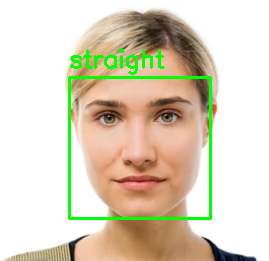

face-2.png: right


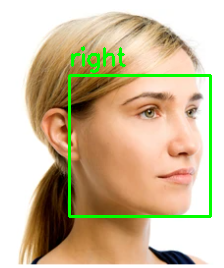

face-1.png: left


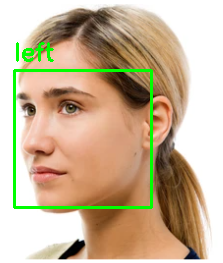

In [12]:
# Assuming 'uploaded' already has the uploaded images
for filename in uploaded.keys():
    image = mp.Image.create_from_file(filename)
    detection_result = detector.detect(image)

    rgb = image.numpy_view()
    annotated, direction = visualize_and_classify(rgb, detection_result)

    print(f"{filename}: {direction}")
    bgr = cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR)
    cv2_imshow(bgr)
